In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torch.autograd import Variable
import pandas as pd
import scipy
import scipy.io as sio
#import sys
#ssys.path.append('../mnist-timit/')
from momentumnet import MomentumLSTMCell
from sklearn.metrics import mean_squared_error as mse



class RNN(nn.Module):
    def __init__(self,input_dim,num_units,batch_size,output_dim):
        super(RNN,self).__init__()
        self.num_units=num_units
        self.input_dim=input_dim
        self.output_dim=output_dim
        self.dropout1=nn.Dropout(p=0.1)
        self.dropout2=nn.Dropout(p=0.1)
        self.lstm1=nn.LSTMCell(input_dim,num_units[0])
        self.lstm2=nn.LSTMCell(num_units[0],num_units[1])
        self.lstm3=nn.LSTMCell(num_units[1],num_units[2])
        #self.lstm1=MomentumLSTMCell(self.input_dim,self.num_units[0],mu=0.9, epsilon=0.1)
        #self.lstm2=MomentumLSTMCell(self.num_units[0],self.num_units[1],mu=0.9,epsilon=0.1)
        #self.lstm3=MomentumLSTMCell(num_units[1],num_units[2],mu=0.9,epsilon=0.1)
        self.linear=nn.Linear(num_units[-1],self.output_dim)
        
    def forward(self,input):
        #print(input.size[1])
        h_t = torch.zeros(input.size(0), self.num_units[0], dtype=torch.float)
        c_t = torch.zeros(input.size(0), self.num_units[0], dtype=torch.float)
        v1 = torch.zeros(input.size(0),  4*self.num_units[0],dtype=torch.float)
        #print(v1.size())
        h_t2 = torch.zeros(input.size(0), self.num_units[1], dtype=torch.float)
        c_t2 = torch.zeros(input.size(0), self.num_units[1], dtype=torch.float)
        v2 = torch.zeros(input.size(0), 4* self.num_units[1],dtype=torch.float)
        h_t3 = torch.zeros(input.size(0), self.num_units[2], dtype=torch.float)
        c_t3 = torch.zeros(input.size(0), self.num_units[2], dtype=torch.float)
        v3 = torch.zeros(input.size(0), 4 * self.num_units[2], dtype=torch.float)
        h_t, c_t = self.lstm1(input, (h_t, c_t))
        h_t=self.dropout1(h_t)
        h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
        h_t2=self.dropout2(h_t2)
        h_t3, c_t3=self.lstm3(h_t2, (h_t3, c_t3))
        #h_t, _, _ = self.lstm1(h_t, (h_t, c_t), v1)
        #h_t2, _, _ = self.lstm2(h_t, (h_t2, c_t2), v2)
        #h_t2=self.dropout2(h_t2)
        #h_t3, _, _ = self.lstm3(h_t2, (h_t3, c_t3),v3)
        #output = torch.tanh(self.linear(h_t3))
        output=self.linear(h_t3)
        return output

#sys.path.remove('../mnist-timit/')
def generate_data(file_num,suffix,placeholder=[]):
    for num in file_num:
        file_name='event'+str(num)+suffix
        temp=sio.loadmat(file_name)['bus_v']
        placeholder.append(temp)
    return placeholder


#for num in file_num:
    #file_name='event'+str(num)+'a1a16.mat'
    #temp=sio.loadmat(file_name)['bus_v']
    #data_train.append(temp)
    

predictions=300
samples=500
n_outputs=predictions
n_hidden=100
n_steps=25
#num_units=[200,300,500]
num_units=[160,180,160]
batch_size=70

X_train=np.empty((batch_size,samples),dtype=np.float32)
Y_train=np.empty((batch_size,predictions),dtype=np.float32)
X_test=np.empty((batch_size,samples),dtype=np.float32)
Y_test=np.empty((batch_size,predictions),dtype=np.float32)
#for i in range(batch_size):
    #t=np.arange(0,samples+predictions)/100.0+i/float(batch_size)
    #y=np.sin(2*np.pi*t)
    #X_train[i,:]=y[:samples]
    #Y_train[i,:]=y[samples:]
    
file_num1=[71,72,73,74,75]   
suffix1='a1a16.mat'
file_num3=[196,197,198,199,200]
suffix3='a1a41.mat'
placeholder=generate_data(file_num1,suffix1)    
    
data_train=[]   
for i in range(len(placeholder)):
    X_train[:,:]=placeholder[i][:,200:700]
    Y_train[:,:]=placeholder[i][:,700:1000]
    data_train.append([X_train,Y_train])
X_test[:,:],Y_test[:,:]=data_train[1]
data_train.remove(data_train[1])

'''
file_num2=[186,187,188,189,190]
suffix2='a1a39.mat'
placeholder=generate_data(file_num2,suffix2,[])
print(len(placeholder))
for i in range(len(placeholder)):
    X_train[:,:]=placeholder[i][:,200:900]
    Y_train[:,:]=placeholder[i][:,900:1000]
    data_train.append([X_train,Y_train])
X_test[:,:],Y_test[:,:]=data_train[2]
data_train.remove(data_train[2])
'''
#sp=int(batch_size*0.5)
##X_test, Y_test=X_train[sp:,:], Y_train[sp:,:]
#X_train, Y_train=X_train[:sp,:], Y_train[:sp,:]     


net=RNN(input_dim=samples,num_units=num_units,
        batch_size=70,output_dim=predictions)

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
scheduler=torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[40,100,160],gamma=0.1)

for epoch in range(400):
    total_loss=0.0
    for X_train,Y_train in data_train:
        X,Y=torch.from_numpy(X_train),torch.from_numpy(Y_train)
        X,Y=Variable(X),Variable(Y)
        y_pred=net(X)
        criterion=torch.nn.MSELoss()
        loss=criterion(y_pred,Y)
        total_loss+=loss
        optimizer.zero_grad()
        loss.backward()
    optimizer.step()
    if epoch%50==0:
        X,Y=torch.from_numpy(X_test),torch.from_numpy(Y_test)
        X,Y=Variable(X),Variable(Y)
        pred=net(X)
        test_loss=criterion(pred,Y)
        print('Epoch: ',epoch)
        print('Train loss: ', total_loss)
        print('Test Loss:', test_loss)
    
net.eval()
X,Y=torch.from_numpy(X_test),torch.from_numpy(Y_test)
X,Y=Variable(X),Variable(Y)
pred=net(X)
loss=criterion(pred,Y)
pred=pred.data.numpy()

#model=RNN(input_dim=samples,num_units=num_units,
#        batch_size=70,output_dim=predictions)
#model.load_state_dict(torch.load('mLSTM.pt'))
'''
#torch.save(net.state_dict(),'mLSTM1.py')
fig=plt.figure(figsize=(10,10))
#nodes=[0,10,15,20,25,30,40,45,50,55,68,69]


def sort(y_hat,y):
	errors={}
	for i in range(y_hat.shape[0]):
		er=mse(y_hat[i,:],y[i,:])
		errors[str(i)]=er[0]
		errors={k: v for v,k in sorted(errors.items(), key=lambda item: item[1])}
	return errors
print(sort(pred,Y_test))
'''
#nodes=[0,34,35,36,37,38,39,40,41,42,43,69]
nodes=[11,12,13,14,15,16,17,18,19,20,21,22]
#def plotpred(pred,Y_test)
'''
for i,k in enumerate(nodes):
	y_hat=np.concatenate((X_test[k,:],pred[k,:]),axis=None)
	y=np.concatenate((X_test[k,:],Y_test[k,:]),axis=None)
	plt.subplot(6,2,i+1)
	#plt.plot(pred[k,:],label='prediction')
	#plt.plot(Y_test[k,:],label='exact')
	plt.plot(y_hat,label='prediction')
	plt.plot(y,label='exacts')
plt.show()
'''

/usr/lib/python3/dist-packages/ipykernel_launcher.py:101: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/lib/python3/dist-packages/ipykernel_launcher.py:102: ComplexWarning: Casting complex values to real discards the imaginary part


Epoch:  0
Train loss:  tensor(1.8061, grad_fn=<AddBackward0>)
Test Loss: tensor(0.4136, grad_fn=<MseLossBackward>)
Epoch:  50
Train loss:  tensor(0.0203, grad_fn=<AddBackward0>)
Test Loss: tensor(0.0045, grad_fn=<MseLossBackward>)
Epoch:  100
Train loss:  tensor(0.0137, grad_fn=<AddBackward0>)
Test Loss: tensor(0.0037, grad_fn=<MseLossBackward>)
Epoch:  150
Train loss:  tensor(0.0175, grad_fn=<AddBackward0>)
Test Loss: tensor(0.0049, grad_fn=<MseLossBackward>)
Epoch:  200
Train loss:  tensor(0.0130, grad_fn=<AddBackward0>)
Test Loss: tensor(0.0046, grad_fn=<MseLossBackward>)
Epoch:  250
Train loss:  tensor(0.0108, grad_fn=<AddBackward0>)
Test Loss: tensor(0.0029, grad_fn=<MseLossBackward>)
Epoch:  300
Train loss:  tensor(0.0056, grad_fn=<AddBackward0>)
Test Loss: tensor(0.0008, grad_fn=<MseLossBackward>)
Epoch:  350
Train loss:  tensor(0.0056, grad_fn=<AddBackward0>)
Test Loss: tensor(0.0012, grad_fn=<MseLossBackward>)


"\nfor i,k in enumerate(nodes):\n\ty_hat=np.concatenate((X_test[k,:],pred[k,:]),axis=None)\n\ty=np.concatenate((X_test[k,:],Y_test[k,:]),axis=None)\n\tplt.subplot(6,2,i+1)\n\t#plt.plot(pred[k,:],label='prediction')\n\t#plt.plot(Y_test[k,:],label='exact')\n\tplt.plot(y_hat,label='prediction')\n\tplt.plot(y,label='exacts')\nplt.show()\n"

In [42]:
def bsort(u,v):
    n=len(u)
    for i in range(n-1):
        for j in range(n-i-1):
            if u[j]>u[j+1]:
                u[j], u[j+1]=u[j+1], u[j]
                v[j], v[j+1]=v[j+1], v[j]
    return u, v

In [47]:
from sklearn.metrics import mean_squared_error as mse
index=[]
errors=[]
for i in range(70):
    index.append(i)
    errors.append(mse(Y_test[i,:],pred[i,:]))
errors, index=bsort(errors,index)

The best 5 nodes
error:  9.802014e-07


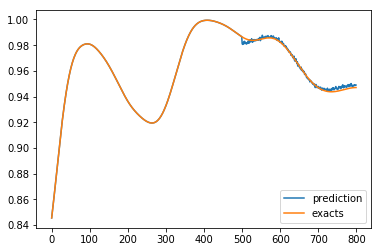

error:  7.0644933e-06


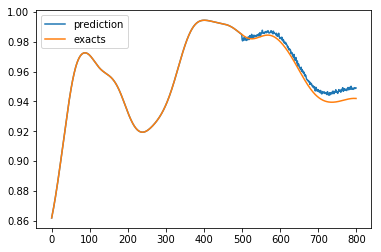

error:  7.424478e-06


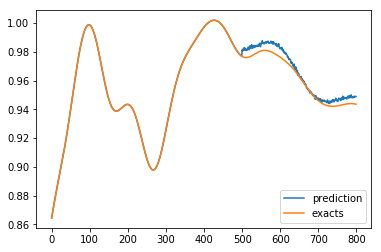

error:  8.08527e-06


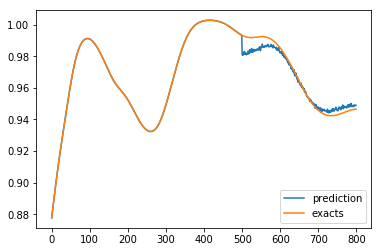

error:  1.1871135e-05


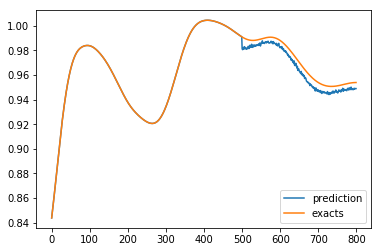

In [44]:
print('The best 5 nodes')
for i in range(5):
    node=index[i]
    y_hat=np.concatenate((X_test[node,:],pred[node,:]),axis=None)
    y=np.concatenate((X_test[node,:],Y_test[node,:]),axis=None)
    print('error: ', mse(y,y_hat))
    plt.plot(y_hat,label='prediction')
    plt.plot(y,label='exacts')
    plt.legend()
    plt.show()


The worst 5 nodes
error:  0.0042958856


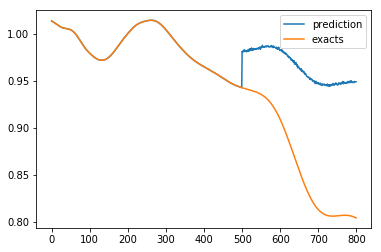

error:  0.0032029233


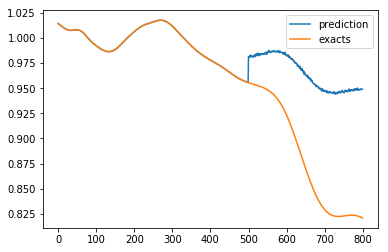

error:  0.0031455187


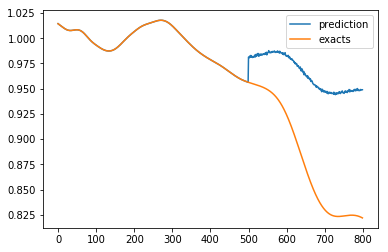

error:  0.0030353875


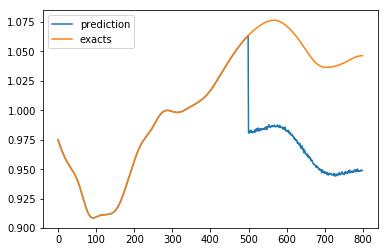

error:  0.0026068792


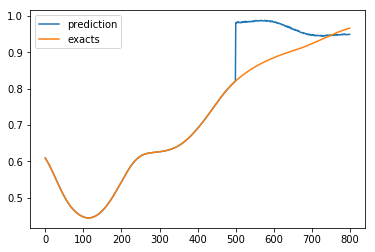

In [45]:
print('The worst 5 nodes')
for i in range(5):
    node=index[-(i+1)]
    y_hat=np.concatenate((X_test[node,:],pred[node,:]),axis=None)
    y=np.concatenate((X_test[node,:],Y_test[node,:]),axis=None)
    print('error: ', mse(y,y_hat))
    plt.plot(y_hat,label='prediction')
    plt.plot(y,label='exacts')
    plt.legend()
    plt.show()

The best 5 nodes
error:  8.534869e-06


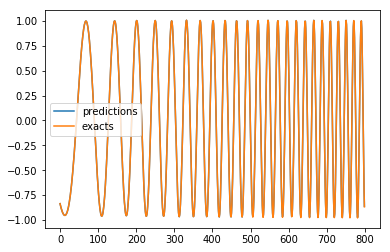

error:  1.0243629e-05


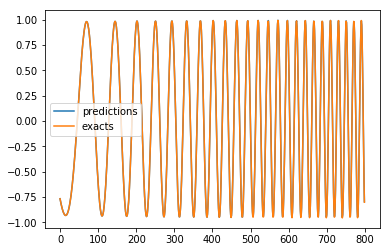

error:  1.489431e-05


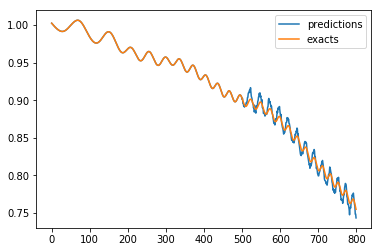

error:  1.5155898e-05


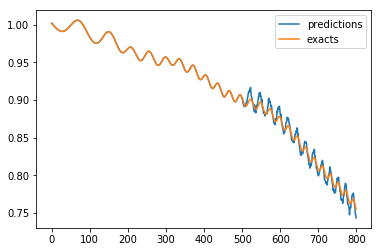

error:  1.764015e-05


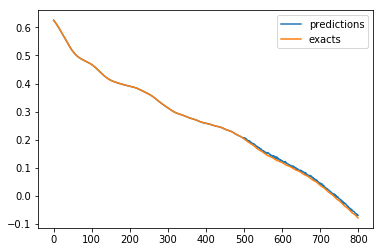

In [48]:
print('The best 5 nodes')
for i in range(5):
    node=index[i]
    y_hat=np.concatenate((X_test[node,:],pred[node,:]),axis=None)
    y=np.concatenate((X_test[node,:],Y_test[node,:]),axis=None)
    print('error: ', mse(y,y_hat))   
    plt.plot(y_hat,label='predictions')
    plt.plot(y,label='exacts')
    plt.legend()
    plt.show()


The worst 5 nodes
error:  0.0014709163


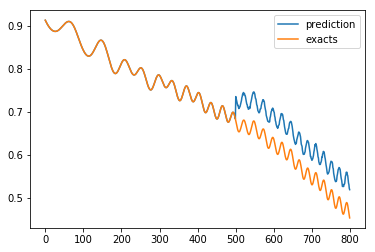

error:  0.0014550766


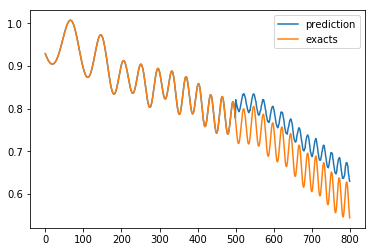

error:  0.001374519


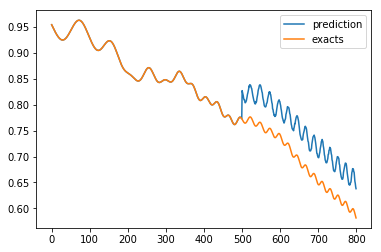

error:  0.0013112552


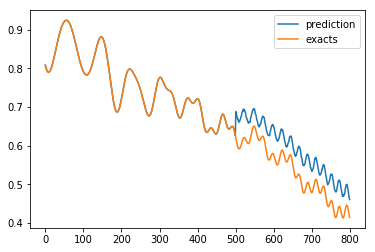

error:  0.0012074985


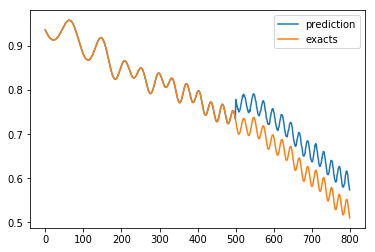

In [50]:
print('The worst 5 nodes')
for i in range(5):
    node=index[-(i+1)]
    y_hat=np.concatenate((X_test[node,:],pred[node,:]),axis=None)
    y=np.concatenate((X_test[node,:],Y_test[node,:]),axis=None)
    print('error: ',mse(y_hat,y))
    plt.plot(y_hat,label='prediction')
    plt.plot(y,label='exacts')
    plt.legend()
    plt.show()